# 의문
feature는 경기 결과의 일부인데 이걸로 점수를 예측하는 것이 경기 결과 예측이라고 할 수 있는지?

## Main idea
1. Extract winning team's features
2. Learn features with LinearRegression 
3. Test each teams' result and find which team is more similar to learned features
4. predict which team will win

## Import library & Dataset

In [ ]:
pip install numpy pandas seaborn scikit-learn seaborn

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

In [3]:
TRAIN_DATA_SRC='./Data/Trainset/Trainset.csv'
TEST_DATA_SRC='./Data/Testset/Testset.csv'
train_df=pd.read_csv(TRAIN_DATA_SRC)
test_df=pd.read_csv(TEST_DATA_SRC)

features=['Possesion','Shots_on_target','Shots','Touches','Passes','Tackles','Clearance','Corners','Offsides','Yellow_cards','Fouls_conceded','Red_cards']

## Preprocess trainset & testset

In [26]:
home_features=[features for features in list(train_df) if 'home' in features and 'team' not in features and 'Score' not in features]
away_features=[features for features in list(train_df) if 'away' in features and 'team' not in features and 'Score' not in features]

winning_train_df=pd.DataFrame(columns=features)
losing_train_df=pd.DataFrame(columns=features)
winning_test_df=pd.DataFrame(columns=features)
losing_test_df=pd.DataFrame(columns=features)

for i,row in train_df.iterrows():
    if row[3]>row[4]:
        winning_train_df.loc[i]=list(row[home_features])
        losing_train_df.loc[i]=list(row[away_features])
    elif row[4]>row[3]:
        winning_train_df.loc[i]=list(row[away_features])
        losing_train_df.loc[i]=list(row[home_features])

for i,row in test_df.iterrows():
    if row[3]>row[4]:
        winning_test_df.loc[i]=list(row[home_features])
        losing_test_df.loc[i]=list(row[away_features])
    elif row[4]>row[3]:
        winning_test_df.loc[i]=list(row[away_features])
        losing_test_df.loc[i]=list(row[home_features])


## PCA

In [5]:
pca=PCA(n_components='mle')
scaler=StandardScaler()
standardized_winning_train_df=pd.DataFrame(scaler.fit_transform(winning_train_df),columns=features)
pca_winning_train_df=pca.fit_transform(standardized_winning_train_df)
pov=pca.explained_variance_
print(pov)

[4.05861052 1.35979163 1.19311343 1.07502493 0.97270886 0.9155342
 0.74296156 0.68236642 0.60193765 0.26418056 0.11750118]


In [6]:
print(sum(pov[:7])/sum(pov))

0.8609793710708921


n_components가 앞 6개의 feature까지는 설명력이 .9 이상이지만 7번째부터 확연히 줄어들기 때문에 PoV가 .86이더라도 feature를 줄이는 것이 나을 것이라고 판단. 
n_components는 6으로 진행.

In [7]:
pca=PCA(n_components=6)
pca_winning_train_df=pd.DataFrame(pca.fit_transform(standardized_winning_train_df))

근데 어떤 feature가 설명력이 높은지 알아야 앞으로 test에서 사용할 수 있음.
아니면 testset을 2007-2022 data를 전부 합쳐서 pca를 진행하고 split_train_test 함수로 쪼개야함.

C:\Users\류호준학부재학컴퓨터학과\AppData\Local\Temp\ipykernel_9640\2733300156.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=train_df.corr()


<AxesSubplot: >

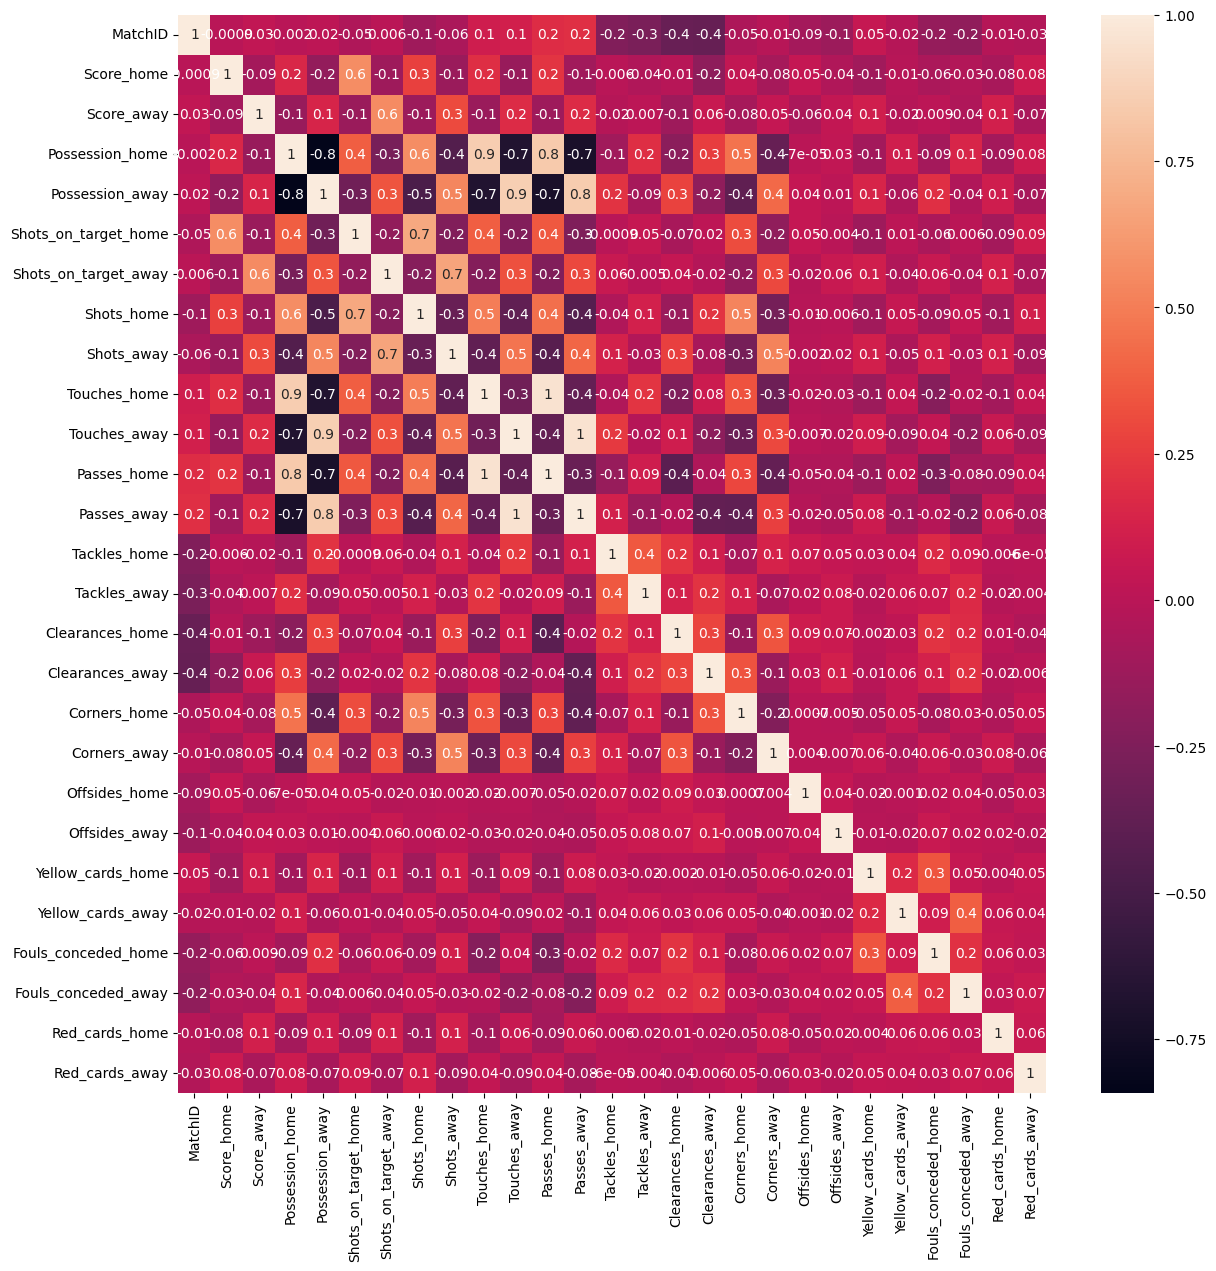

In [30]:
plt.figure(figsize=(14,14))
corr=train_df.corr()
sns.heatmap(corr,annot=True,fmt='.1g')

## Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [17]:
X_train=train_df.drop(columns=['MatchID','Home_team','Away_team','Score_home','Score_away']).values
standardized_X_train=pd.DataFrame(scaler.fit_transform(X_train))
y_train=train_df['Score_home'].values

X_test=test_df.drop(columns=['MatchID','Home_team','Away_team','Score_home','Score_away']).values
standardized_X_test=pd.DataFrame(scaler.fit_transform(X_test))
y_test=test_df['Score_home'].values


In [22]:
X_train.shape

(5318, 24)

In [23]:
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
predictions=lin_reg.predict(X_test)
lin_mse=mean_squared_error(y_test,predictions)
lin_rmse=np.sqrt(lin_mse)
print("RMSE: ",lin_rmse)
print("Score: ",lin_reg.score(X_test,y_test))

RMSE:  0.9969077726364975
Score:  0.43319843922805623


Dataset이 늘어나서 RMSE가 1이하로 내려갔지만 여전히 큼...  
만약 정규화 하면?

In [18]:
lin_reg.fit(standardized_X_train,y_train)
predictions=lin_reg.predict(standardized_X_test)
lin_mse=mean_squared_error(y_test,predictions)
lin_rmse=np.sqrt(lin_mse)
print("RMSE: ",lin_rmse)

RMSE:  0.9817655638215391


쪼오오금 줄어듦...  
다른 정규화 방법도 찾아봐야될듯

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
log_reg=LogisticRegression()
log_reg.fit(X_train,y_train)
predictions=log_reg.predict(X_test)
log_rmse=np.sqrt(mean_squared_error(y_test,predictions))
print("RMSE: ",log_rmse)

RMSE:  1.2840109853604509


c:\Users\류호준학부재학컴퓨터학과\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
